In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

In [63]:
orders = pd.read_csv(
    "../data/input/part1-dataset.csv", parse_dates= ["created_date", "first_created_at"]
)

In [64]:
orders.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,300000,250000,1
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,470000,230000,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,160000,160000,1
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,33.672604,52.686855,34.654903,53.704929,950000,530000,530000,1
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,360000,230000,1


Exploratory Data Analysi

In [65]:
orders = orders.assign(first_created_at_hour=orders["first_created_at"].dt.hour)

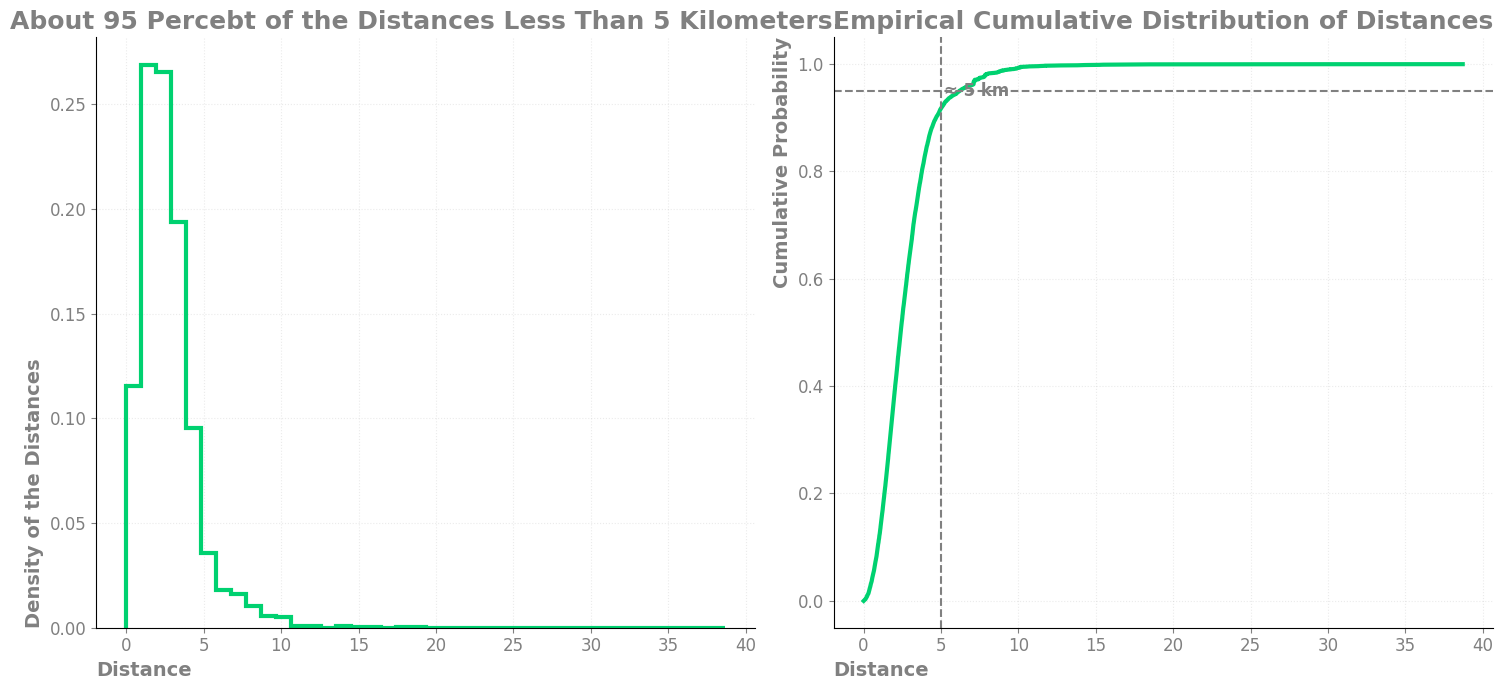

In [66]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].hist(
    orders["total_distance"],
    color = '#00D170',
    bins = 40,
    density = True,
    histtype = 'step',
    lw = 3,
)

ax[0].spines[["right", "top"]].set_visible(False)
ax[0].set_ylabel(
    "Density of the Distances",
    loc = "bottom",
    weight = "bold",
    fontsize = 14,
    color = "gray",
)

ax[0].set_xlabel("Distance", loc = "left", weight = "bold", fontsize = 14, color = "gray")
ax[0].set_title(
    "About 95 Percebt of the Distances Less Than 5 Kilometers.",
    weight = "bold",
    color = 'gray',
    fontsize = 18,
)

d = orders["total_distance"].values
d_sorted = np.sort(d)
y_vals = np.arange(1, len(d_sorted)+1) / len(d_sorted)

ax[1].plot(d_sorted, y_vals, color="#00D170", lw=3)

ax[1].axhline(0.95, color="gray", ls="--", lw=1.5)

ax[1].axvline(5, color="gray", ls="--", lw=1.5)
ax[1].text(5.2, 0.95, "≈ 5 km", va="center", ha="left",
           weight="bold", color="gray", fontsize=12)

ax[1].spines[["right", "top"]].set_visible(False)
ax[1].set_xlabel("Distance", loc="left", weight="bold", fontsize=14, color="gray")
ax[1].set_ylabel("Cumulative Probability",
                 loc="top", weight="bold", fontsize=14, color="gray")
ax[1].set_title(
    "Empirical Cumulative Distribution of Distances",
    weight="bold", color="gray", fontsize=18,
)

for axis in ax:
    axis.tick_params(axis="both", labelsize=12, colors="gray")
    axis.grid(alpha=0.25, ls=":")

plt.tight_layout()

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "About 95 Percebt of the Distances Less Than 5 Kilometers.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)

plt.show()

In [67]:
normal_hyper_ack_status = (
    orders
    .groupby(["first_created_at_hour", "hyper_ack"], as_index=False)
    .agg(total_order=("hyper_ack", "count"))
    .pivot_table(
        index="first_created_at_hour",
        columns="hyper_ack",
        values="total_order"
    )
    .reset_index()
    .rename(columns={0.0: "normal", 1.0: "hyper_ack"})   # 0.0 / 1.0 not 0 / 1
    .fillna(0)
    .assign(total_hour_order=lambda df: df["normal"] + df["hyper_ack"])
    .assign(share_hyper_ack=lambda df: df["hyper_ack"] / df["total_hour_order"])
    .query("total_hour_order != 1")
)

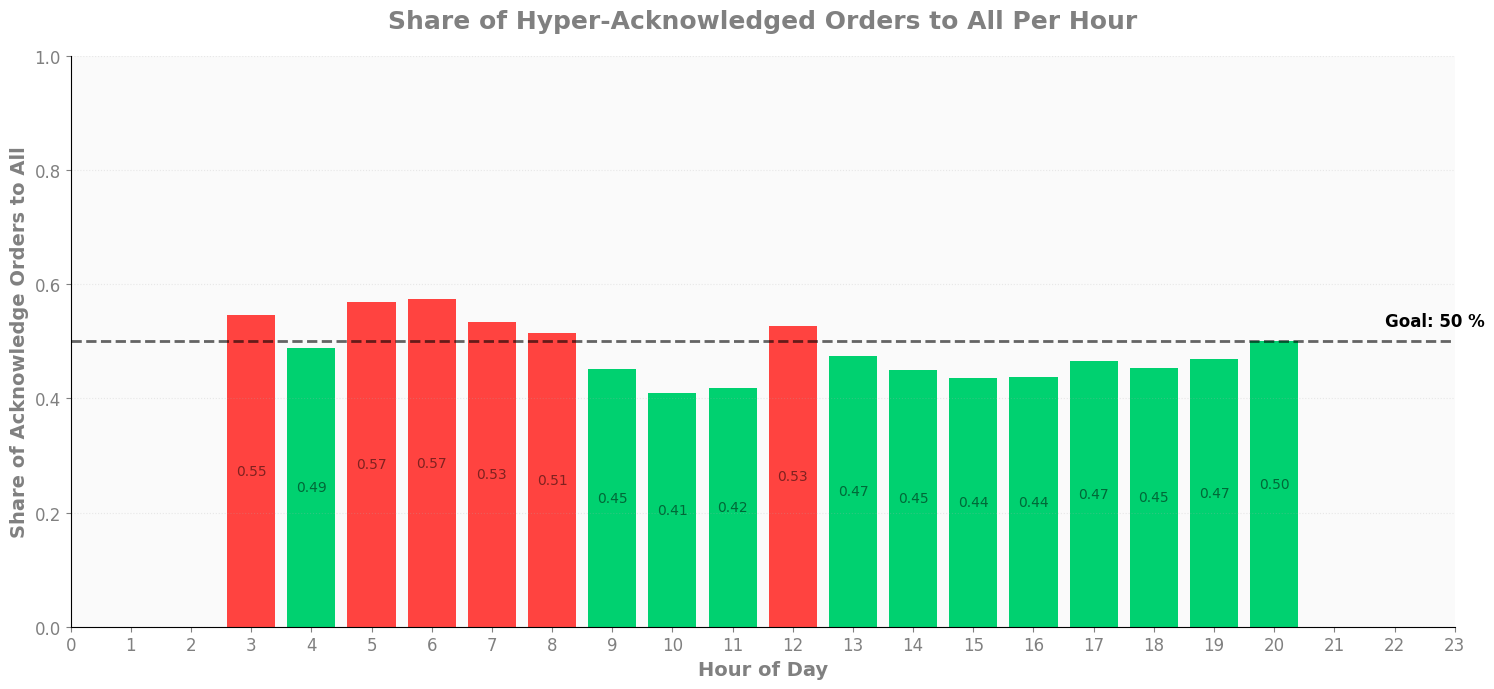

In [68]:
fig, ax = plt.subplots(figsize=(15, 7))

rect_share = ax.bar(
    normal_hyper_ack_status["first_created_at_hour"],
    normal_hyper_ack_status["share_hyper_ack"],
    color=np.where(
        normal_hyper_ack_status["share_hyper_ack"].gt(0.5),
        "#FF4340", "#00D170"
    ),
)
ax.axhline(0.5, ls='--', color='black', lw=2, alpha=0.6)
ax.text(23.5, 0.52, "Goal: 50 %", va='bottom', ha='right',
        fontsize=12, weight='bold', color='black')

ax.bar_label(rect_share, label_type="center", fmt="%.2f", alpha=0.5)
ax.set_title("Share of Hyper-Acknowledged Orders to All Per Hour",
             weight="bold", fontsize=18, color="gray", pad=20)
ax.set_xlabel("Hour of Day", weight="bold", fontsize=14, color="gray")
ax.set_ylabel("Share of Acknowledge Orders to All", weight="bold", fontsize=14, color="gray")
ax.set_ylim(0, 1)
ax.set_xticks(range(0, 24))
ax.spines[["right", "top"]].set_visible(False)
ax.tick_params(axis="both", labelsize=12, colors="gray")
ax.grid(axis="y", alpha=.25, ls=":")
ax.set_facecolor("#fafafa")

plt.tight_layout()
# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Share of Hyper-Acknowledged Orders to All Per Hour.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)
plt.show()

In [69]:
daily_orders = (
    orders.groupby(["created_date"], as_index=False)
    .agg(daily_orders=("created_date", "count"))
    .set_index("created_date")
    .iloc[:-1]
)

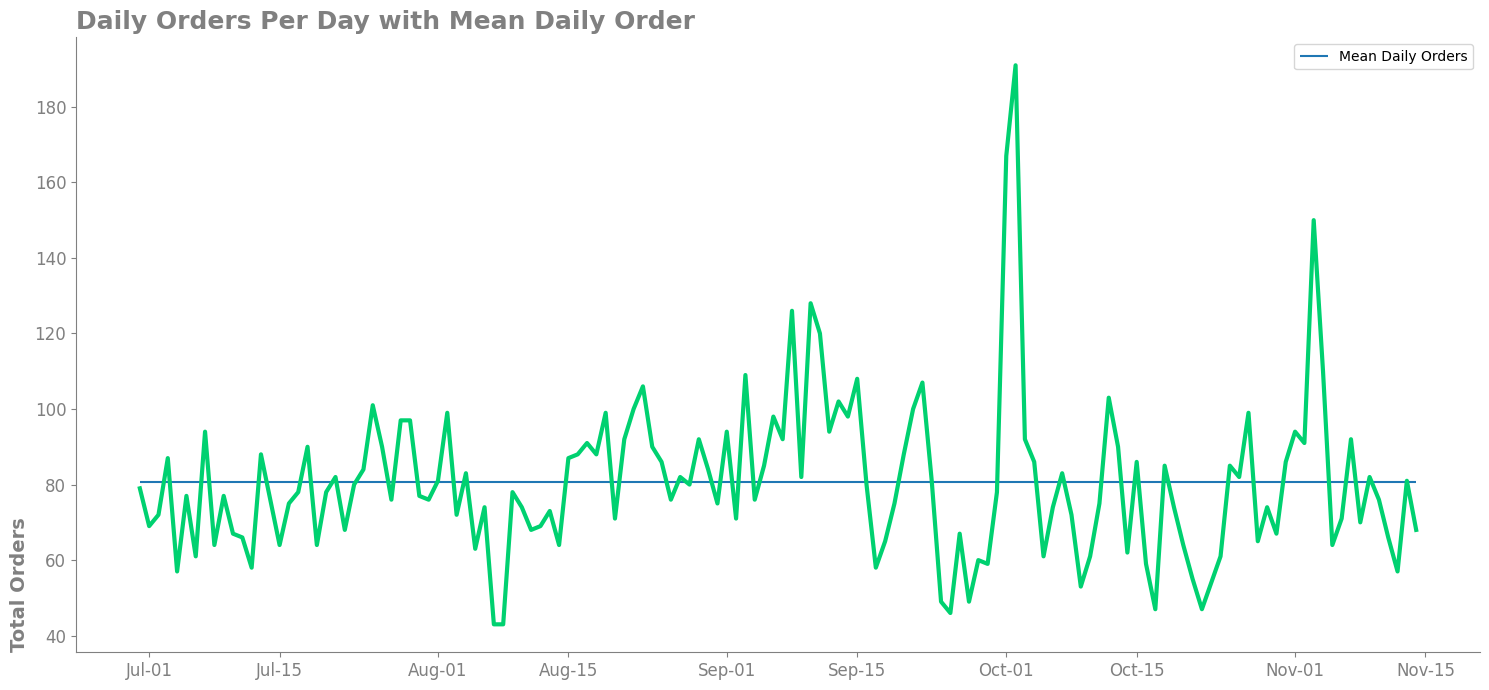

In [70]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.hlines(
    daily_orders["daily_orders"].mean(),
    xmin=daily_orders.index.min(),   
    xmax=daily_orders.index.max(),   
    label="Mean Daily Orders"
)

ax.plot(daily_orders, lw=3, color = "#00D170")
ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("gray")
ax.tick_params(axis="x", colors="gray", labelsize="large") 
ax.tick_params(axis="y", colors="gray", labelsize="large")  

ax.set_ylabel(
    "Total Orders",
    weight="bold",
    color="gray",
    fontsize=14,
    loc="bottom",
)

ax.set_title(
    "Daily Orders Per Day with Mean Daily Order",
    weight="bold",
    color="gray",
    fontsize=18,
    loc="left",
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d")) 
ax.tick_params(axis='x')

plt.legend()
plt.tight_layout()
# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Daily Orders Per Day with Mean Daily Order.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)
plt.show()


In [71]:
normal_hyper_ack_per_category = (
    orders
    .groupby(["deliverey_category_id", "hyper_ack"], as_index=False)
    .agg(total_order=("hyper_ack", "count"))
    .pivot_table(
        index="deliverey_category_id",  
        columns="hyper_ack",
        values="total_order"
    )
    .reset_index()
    .rename(columns={0: "normal", 1: "hyper_ack"})
    .assign(total_category_order=lambda df: df["normal"] + df["hyper_ack"])
    .assign(share_hyper_ack=lambda df: df["hyper_ack"] / df["total_category_order"])
)

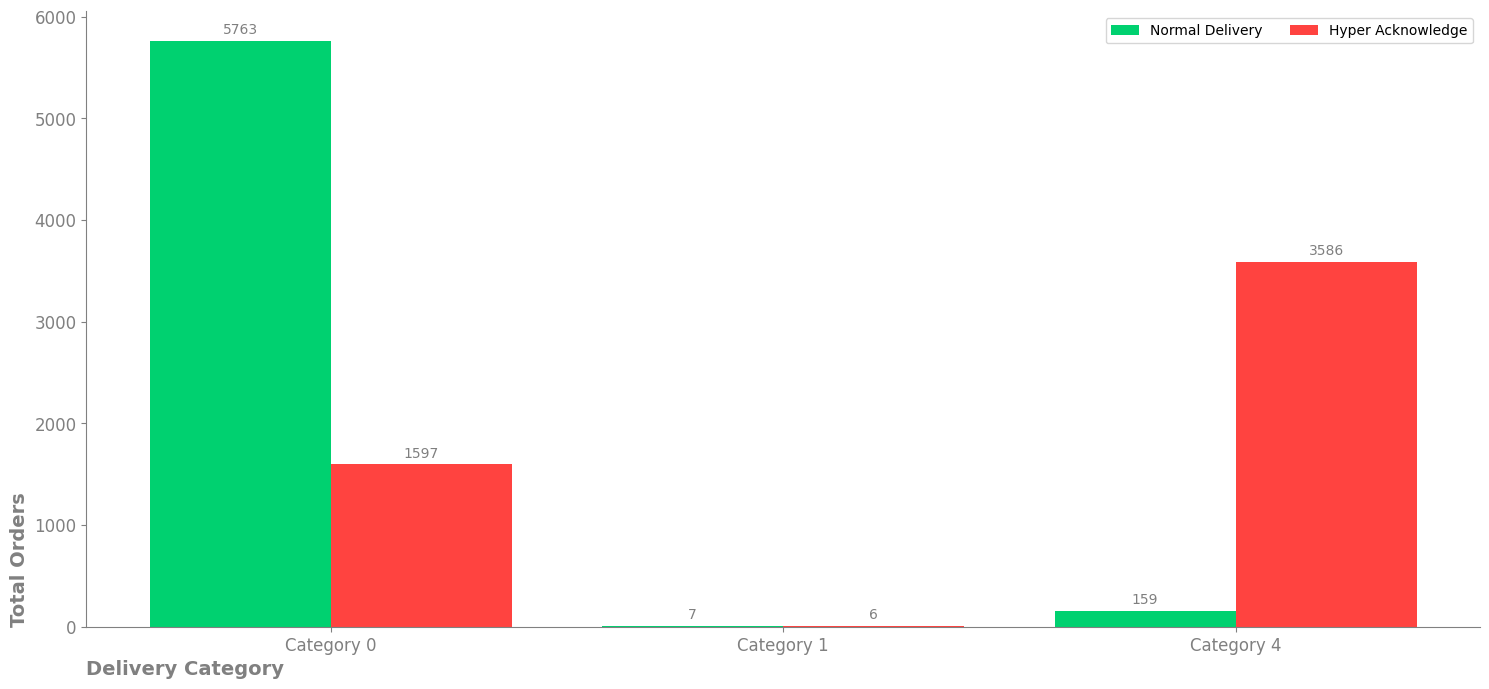

In [72]:
fig, ax = plt.subplots(figsize = (15,7))

x = np.arange(len(normal_hyper_ack_per_category))
rect_normal = ax.bar(
    x - 0.2,
    normal_hyper_ack_per_category["normal"],
    0.4,
    label = "Normal Delivery",
    color="#00D170",
)
ax.bar_label(rect_normal, padding=3, alpha=0.5)

rect_ack = ax.bar(
    x + 0.2,
    normal_hyper_ack_per_category["hyper_ack"],
    0.4,
    label = "Hyper Acknowledge",
    color="#FF4340",
)
ax.bar_label(rect_ack, padding=3, alpha=0.5)

ax.set_ylabel(
    "Total Orders",
    loc = "bottom",
    weight = "bold",
    fontsize = 14,
    color = "gray",
)

ax.set_xlabel("Delivery Category", loc = "left", weight = "bold", fontsize =14, color="gray")

ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color('gray')
ax.tick_params(axis="x", colors="gray", labelsize="large")
ax.tick_params(axis="y", colors="gray", labelsize="large")

ax.set_xticks(x, ['Category 0', 'Category 1', 'Category 4'])
plt.legend(ncols = 2)
plt.tight_layout()
# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Delivery Category.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)
plt.show()

Future Extraction

Extract Hour and Descrete Sum Production

In [73]:
orders = orders.assign(
    first_created_at_hour=orders["first_created_at"].dt.hour
)

Cluster Locations

In [74]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [75]:
destination_geo_locations = orders[["destination_latitude", "destination_longitude"]]
source_geo_locations = orders[["source_latitude", "source_longitude"]]

In [76]:
destination_geo_locations

,destination_latitude,destination_longitude
0,31.602938,54.477932
1,38.305122,61.677757
2,34.628998,53.630806
3,34.654903,53.704929
4,37.827084,52.974762
...,...,...
11113,31.619459,54.537998
11114,34.627125,53.707272
11115,38.299927,61.521576
11116,34.637890,53.656868


In [77]:
source_geo_locations

,source_latitude,source_longitude
0,30.604658,53.503632
1,37.306400,60.657444
2,33.629711,52.633621
3,33.672604,52.686855
4,36.820545,51.996281
...,...,...
11113,30.632278,53.538078
11114,33.644917,52.722286
11115,37.297375,60.523220
11116,33.622696,52.655704


In [78]:
n_clusters = 1    # initializing kmeans clusters
clustering_pipeline = Pipeline(
    [
        ("preprecessor", StandardScaler()),
        (
            "clusterer",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            )
        )
    ]
)

In [79]:
source_sum_of_squared_distances = (
    []
)
for cluster in range(1,11):
    kmeans_model = clustering_pipeline.set_params(clusterer__n_clusters=cluster)
    estimator = clustering_pipeline.fit(source_geo_locations)
    source_sum_of_squared_distances.append(kmeans_model["clusterer"].inertia_)

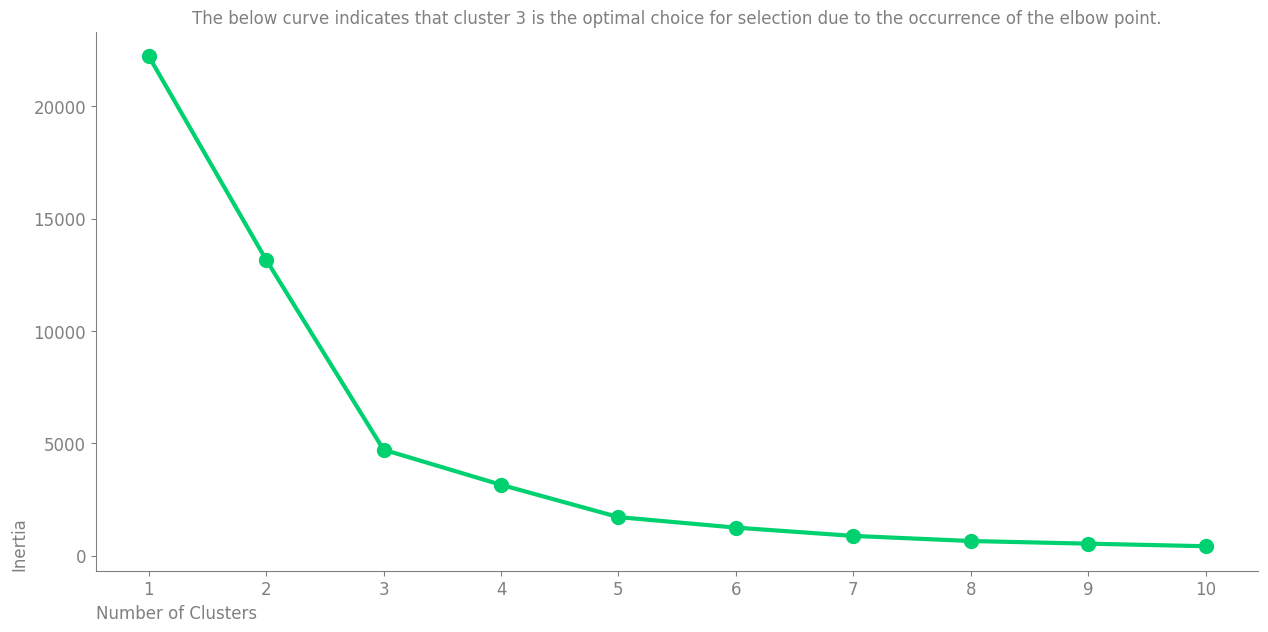

In [80]:
fig, ax = plt.subplots(figsize = (15,7))

ax.plot(
    range(1,11),
    source_sum_of_squared_distances,
    marker = "o",
    color="#00D170",
    lw = 3,
    ms=10,
)
ax.set_xticks(range(1,11))

ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("gray")
ax.tick_params(axis="x", colors="gray", labelsize="large")
ax.tick_params(axis="y", colors="gray", labelsize="large")

ax.set_ylabel(
    "Inertia",
    color="gray",
    fontsize="large",
    loc="bottom"
)

ax.set_xlabel(
    "Number of Clusters",
    color="gray",
    fontsize="large",
    loc="left"
)

ax.set_title(
    "The below curve indicates that cluster 3 is the optimal choice for selection due to the occurrence of the elbow point.",
    color="gray",
    fontsize="large"
)

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Number of Clusters.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)


plt.show()

In [81]:
kmeans_model = clustering_pipeline.set_params(clusterer__n_clusters=3)
source_estimator = clustering_pipeline.fit(source_geo_locations)
labels = clustering_pipeline.predict(source_geo_locations)
source_labels = pd.Series(labels, name = "source_cluster")

In [82]:
source_labels

0        2
1        1
2        2
3        2
4        0
        ..
11113    2
11114    2
11115    1
11116    2
11117    0
Name: source_cluster, Length: 11118, dtype: int32

In [83]:
import os
import joblib

os.makedirs("app/models", exist_ok=True)         
joblib.dump(clustering_pipeline,               
          "app/models/clustering_source_location.joblib")

['app/models/clustering_source_location.joblib']

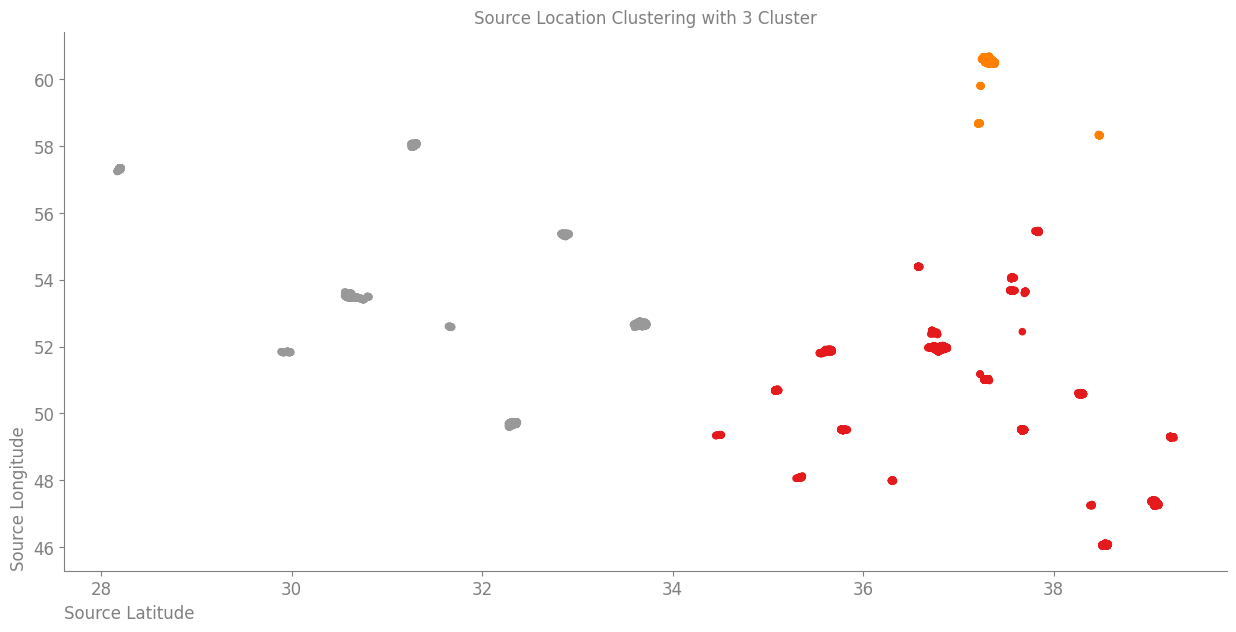

In [84]:
fig, ax = plt.subplots(figsize = (15,7))
ax.scatter(
    source_geo_locations.iloc[:, 0],
    source_geo_locations.iloc[:, 1],
    c = labels,
    s = 20,
    cmap="Set1"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("gray")
ax.tick_params(axis= "x", colors= "gray", labelsize= "large")
ax.tick_params(axis= "y", colors= "gray", labelsize= "large")

ax.set_ylabel(
    "Source Longitude",
    loc = "bottom",
    color="gray",
    fontsize="large"
    
)

ax.set_xlabel(
    "Source Latitude",
    color="gray",
    fontsize="large",
    loc="left"
)

ax.set_title(
    "Source Location Clustering with 3 Cluster",
    color="gray",
    fontsize="large"
)

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Source Location Clustering with 3 Cluster.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)

plt.show()

In [85]:
destination_sum_of_squared_distances = (
    []
)
for cluster in range(1,11):
    kmeans_model= clustering_pipeline.set_params(clusterer__n_clusters=cluster)
    estimator = clustering_pipeline.fit(destination_geo_locations)
    destination_sum_of_squared_distances.append(kmeans_model["clusterer"].inertia_)


In [86]:
kmeans_model = clustering_pipeline.set_params(clusterer__n_clusters=cluster)
destination_estimator = clustering_pipeline.fit(destination_geo_locations)
labels = clustering_pipeline.predict(destination_geo_locations)
destination_labels = pd.Series(labels, name = "destination_cluster")

In [87]:
joblib.dump(destination_estimator, "app/models/clustering_destination_location.joblib")

['app/models/clustering_destination_location.joblib']

In [88]:
orders_features = pd.concat(
    [orders, destination_labels, source_labels], axis="columns"
).drop(
    columns=[
        "source_latitude",
        "source_longitude",
        "destination_latitude",
        "destination_longitude",
    ]
)

In [89]:
orders_features.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,first_created_at_hour,destination_cluster,source_cluster
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,300000,300000,250000,1,15,1,2
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,470000,470000,230000,1,10,2,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,160000,160000,160000,1,10,4,2
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,950000,530000,530000,1,9,4,2
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,450000,360000,230000,1,8,9,0


**Future Analysis**

In [90]:
CORRELATION_COLUMNS = [
    "weekday",
    "time_bucket",
    "total_distance",
    "sum_product",
    "source_cluster",
    "destination_cluster",
    "final_customer_fare",
    "final_biker_fare",
    "first_customer_fare",
    "hyper_ack"
]

In [91]:
print(orders_features.columns.tolist())

['created_date', 'deliverey_category_id', 'weekday', 'first_created_at', 'time_bucket', 'total_distance', 'sum_product', 'final_customer_fare', 'final_biker_fare', 'first_customer_fare', 'hyper_ack', 'first_created_at_hour', 'destination_cluster', 'source_cluster']


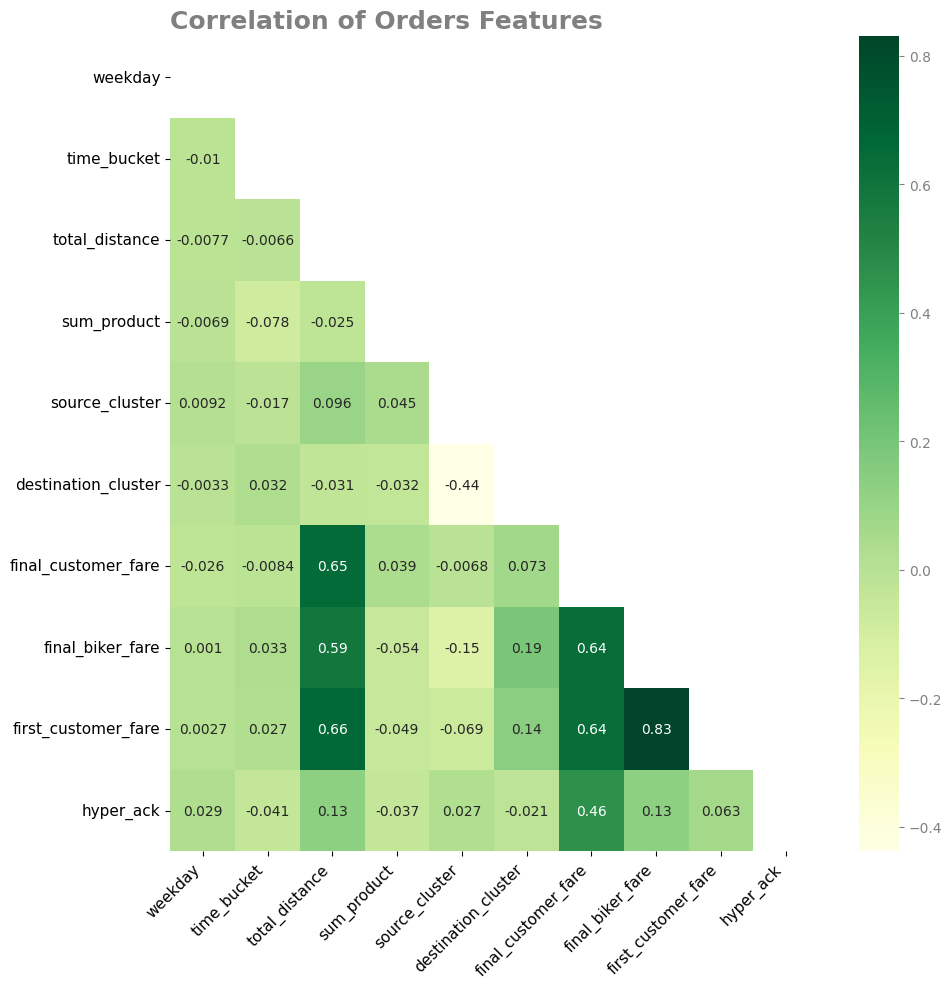

In [92]:
corr_df = orders_features[CORRELATION_COLUMNS].corr()

matrix = np.triu(np.ones_like(corr_df, dtype=bool)) 

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(
    corr_df,
    cmap="YlGn",
    annot=True,
    mask=matrix,
    ax=ax
)
ax.set_title(
    "Correlation of Orders Features",
    weight = "bold",
    color = "gray",
    fontsize = 18,
    loc = "left",
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    fontsize=11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=11
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10, colors="gray")
cbar.outline.set_edgecolor("gray")


plt.tight_layout()

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Correlation of Orders Features.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)

plt.show()


In [93]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [94]:
orders_features.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,first_created_at_hour,destination_cluster,source_cluster
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,300000,300000,250000,1,15,1,2
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,470000,470000,230000,1,10,2,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,160000,160000,160000,1,10,4,2
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,950000,530000,530000,1,9,4,2
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,450000,360000,230000,1,8,9,0


In [95]:
orders_features_analysis = orders_features.assign(
    sum_product = (pd.qcut(orders["sum_product"], q=4, labels=range(1,5)))
)

In [96]:
log_reg = smf.logit(
    "hyper_ack ~ C(weekday) + "
    "C(deliverey_category_id) + "    
    "time_bucket + "
    "total_distance + "
    "C(sum_product) + "
    "final_customer_fare + "
    "source_cluster + "
    "destination_cluster + "
    "first_created_at_hour",
    data=orders_features_analysis
).fit()

Optimization terminated successfully.
         Current function value: 0.345209
         Iterations 7


In [97]:
import statsmodels.api as sm
sm.iolib.summary.Summary._repr_html_ = lambda self: self.as_html()

In [98]:
print(log_reg.summary().as_text())

                           Logit Regression Results                           
Dep. Variable:              hyper_ack   No. Observations:                11107
Model:                          Logit   Df Residuals:                    11089
Method:                           MLE   Df Model:                           17
Date:                Wed, 23 Jul 2025   Pseudo R-squ.:                  0.5004
Time:                        13:32:26   Log-Likelihood:                -3834.2
converged:                       True   LL-Null:                       -7674.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.2506      0.204    -11.012      0.000      -2.651      -1.850
C(weekday)[T.2]                  -0.1340      0.113     -1.183      0.237 

In [99]:
odds_ratios = pd.DataFrame(
    {
        "lower_confidence_interval": log_reg.conf_int()[0],
        "odds_ratio": log_reg.params,
        "upper_confidence_interval": log_reg.conf_int()[1],
    }
)
odds_ratio = np.exp(odds_ratios)

In [100]:
odds_ratio

,lower_confidence_interval,odds_ratio,upper_confidence_interval
Intercept,0.070566,0.105334,0.157234
C(weekday)[T.2],0.700523,0.874586,1.091900
C(weekday)[T.3],0.770316,0.961332,1.199713
C(weekday)[T.4],0.642685,0.797339,0.989208
C(weekday)[T.5],0.808760,1.009537,1.260157
C(weekday)[T.6],1.310617,1.623492,2.011058
C(weekday)[T.7],1.389519,1.719365,2.127511
C(deliverey_category_id)[T.1],0.733801,2.316220,7.311081
C(deliverey_category_id)[T.4],55.035015,66.187050,79.598881
C(sum_product)[T.2],0.582355,0.683987,0.803356


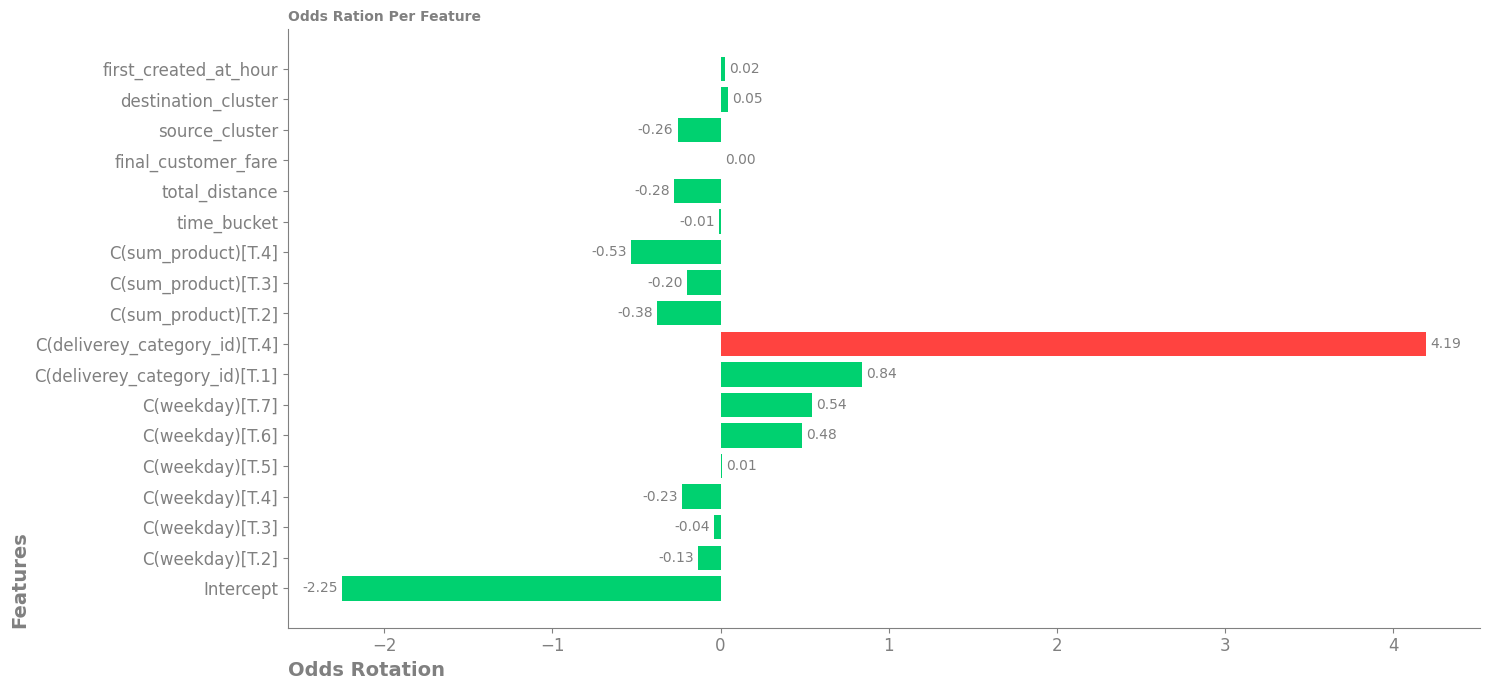

In [101]:
fig, ax = plt.subplots(figsize = (15,7), sharex=True)

rect_share = ax.barh(
    odds_ratios.index,
    odds_ratios["odds_ratio"],
    color = np.where(odds_ratios["odds_ratio"].gt(1), "#FF4340", "#00D170")
)

ax.bar_label(rect_share, padding = 3, fmt = "%.2f", alpha=0.5)
ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("gray")
ax.tick_params(axis= "x", colors= "gray", labelsize= "large")
ax.tick_params(axis= "y", colors= "gray", labelsize= "large")

ax.set_xlabel("Odds Rotation", loc="left", weight="bold", fontsize=14, color="gray")

ax.set_ylabel(
    "Features",
    loc="bottom",
    weight="bold",
    fontsize=14,
    color="gray"
)

ax.set_title(
    "Odds Ration Per Feature",
    weight = "bold",
    color = "gray",
    fontsize = 10,
    loc="left",
)

plt.tight_layout()

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Odds Ration Per Feature.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)


plt.show()

Modeling

In [102]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    KBinsDiscretizer,
)
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, chi2

In [103]:
orders_features.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,first_created_at_hour,destination_cluster,source_cluster
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,300000,300000,250000,1,15,1,2
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,470000,470000,230000,1,10,2,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,160000,160000,160000,1,10,4,2
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,950000,530000,530000,1,9,4,2
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,450000,360000,230000,1,8,9,0


In [104]:
numerical_cols = [
    "time_bucket",
    "total_distance",
    "first_created_at_hour",
    "final_customer_fare"
]

categorical_cols = [
    "deliverey_category_id",
    "weekday",
    "destination_cluster",
    "source_cluster",
]

ordinal_category_cols = ["sum_product"]

In [105]:
num_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), ("scale", MinMaxScaler())]
)
ohe_cat_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        (
            "one-hot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype="int"),
        ),
    ]
)
oe_cat_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            KBinsDiscretizer(
                n_bins=4, encode="ordinal", strategy="quantile"
            ),
        ),
    ]
)

In [106]:
# 1. Re-build the correct lists
numerical_cols = [
    "time_bucket",
    "total_distance",
    "final_customer_fare"
]

categorical_cols = [
    "deliverey_category_id",
    "weekday",
]

ordinal_category_cols = [
    "sum_product",
    "first_created_at_hour",   # <-- correct spelling
    "destination_cluster",
    "source_cluster",
]

# 2. Re-create the ColumnTransformer with the new lists
col_trans = ColumnTransformer(
    transformers=[
        ("num_pipeline", num_pipeline, numerical_cols),
        ("ohe_cat_pipeline", ohe_cat_pipeline, categorical_cols),
        ("oe_cat_pipeline", oe_cat_pipeline, ordinal_category_cols),
    ],
    remainder="drop",
    n_jobs=1,
)

# 3. Re-create the entire pipeline so it uses the new transformer
log_reg_clf_pipleline = Pipeline(
    steps=[
        ("col_trans", col_trans),
        ("selector", feature_selector),
        ("model", LogisticRegression(random_state=0))
    ]
)

# 4. Re-split (just to be safe)
X = orders_features[numerical_cols + categorical_cols + ordinal_category_cols]
y = orders_features["hyper_ack"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Fit again
log_reg_clf_pipleline.fit(X_train, y_train)
score = log_reg_clf_pipleline.score(X_valid, y_valid)
print(f"Model score: {score}")

Model score: 0.858363309352518


c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [107]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(random_state=0)
log_reg_clf_pipleline = Pipeline(
    steps=[
        ("col_trans", col_trans),
        ("selector", feature_selector),
        ("model", log_reg_clf)
    ]
)

In [108]:
from sklearn import set_config

set_config(display="diagram")
display(log_reg_clf_pipleline)


,steps,"[('col_trans', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_pipeline', ...), ('ohe_cat_pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [109]:
all_cols = numerical_cols + categorical_cols + ordinal_category_cols
print(all_cols)

['time_bucket', 'total_distance', 'final_customer_fare', 'deliverey_category_id', 'weekday', 'sum_product', 'first_created_at_hour', 'destination_cluster', 'source_cluster']


In [110]:
numerical_cols = ['time_bucket', 'total_distance', 'final_customer_fare']
categorical_cols = ['weekday', 'deliverey_category_id']
ordinal_category_cols = ['first_created_at_hour',
                         'destination_cluster',
                         'source_cluster',
                         'sum_product']

In [111]:
from sklearn.model_selection import train_test_split

X = orders_features[numerical_cols + categorical_cols + ordinal_category_cols]
y = orders_features["hyper_ack"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [112]:
numerical_cols = [
    "time_bucket",
    "total_distance",
    "final_customer_fare"
]

categorical_cols = [
    "deliverey_category_id",
    "weekday",
]

ordinal_category_cols = [
    "sum_product",
    "first_created_at_hour",   
    "destination_cluster",
    "source_cluster",
]


In [113]:
log_reg_clf_pipleline.fit(X_train, y_train)
score = log_reg_clf_pipleline.score(X_valid, y_valid)
print(f"Model score: {score}")

Model score: 0.858363309352518


c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [114]:
param_grid_logistic_regression = {
    "model__penalty": ["l1", "l2"],
    "model__C": np.logspace(-4, 4, 20),
    "model__solver": ["liblinear"], 
}

In [120]:
from sklearn.model_selection import GridSearchCV

grid_search_logistic_regression = GridSearchCV(
    log_reg_clf_pipleline,
    param_grid=param_grid_logistic_regression,
    cv=5,
    scoring="accuracy",
    verbose=True,
    n_jobs=1,
)

In [121]:
grid_search_logistic_regression.fit(X_train, y_train)

print("Best Score of Train Set:", str(grid_search_logistic_regression.best_score_))
print("Best Parameters:", str(grid_search_logistic_regression.best_params_))
print("Test Score:", str(grid_search_logistic_regression.score(X_valid, y_valid)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version

Best Score of Train Set: 0.8676634223420218
Best Parameters: {'model__C': np.float64(4.281332398719396), 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Test Score: 0.8673561151079137


c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version

In [122]:
y_pred_logistic = grid_search_logistic_regression.predict(X_valid)

In [124]:
y_pred_logistic

array([0, 1, 0, ..., 1, 0, 0], shape=(2224,))

In [123]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score = precision_score(y_valid, y_pred_logistic)
recall_score = recall_score(y_valid, y_pred_logistic)
f1_score = f1_score(y_valid, y_pred_logistic)

print(f"Precision score: {precision_score:.3f}")
print(f"Recall score: {recall_score:.3f}")
print(f"F1 score: {f1_score:.3f}")

Precision score: 0.922
Recall score: 0.782
F1 score: 0.846


In [129]:
from sklearn.metrics import confusion_matrix

confusion_matrix_logistic = confusion_matrix(y_valid, y_pred_logistic)

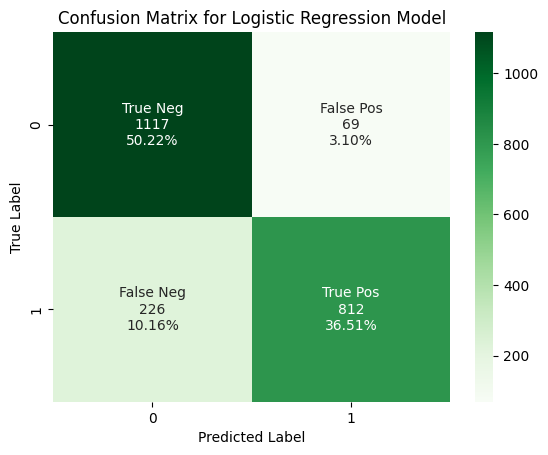

In [137]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]

matrix_values = confusion_matrix_logistic.flatten()

group_counts = ["{0:0.0f}".format(value) for value in matrix_values]
group_percentage = ["{0:.2%}".format(value) for value in matrix_values / np.sum(matrix_values)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentage)]

labels = np.array(labels).reshape(confusion_matrix_logistic.shape)

sns.heatmap(confusion_matrix_logistic, annot=labels, fmt="", cmap="Greens")

plt.title("Confusion Matrix for Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Confusion Matrix for Logistic Regression Model.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)

plt.show()

In [138]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=0)
svc_clf_pipline = Pipeline(
    steps=[
        ("col_trans", col_trans),
        ("selector", feature_selector),
        ("model", svc_clf),
    ]
)

In [139]:
set_config(display="diagram")
display(svc_clf_pipline)

,steps,"[('col_trans', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_pipeline', ...), ('ohe_cat_pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [140]:
svc_clf_pipline.fit(X_train, y_train)
score = svc_clf_pipline.score(X_valid, y_valid)
print(f"Model score: {score}")

c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(


Model score: 0.8421762589928058


In [141]:
param_grid_svc = {
    "model__C": [0.1, 1, 100, 1000],
    "model__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "model__kernel": ["rbf"]
}

In [142]:
grid_search_svc = GridSearchCV(
    svc_clf_pipline,
    param_grid=param_grid_svc,
    cv=5,
    scoring="roc_auc",
    verbose=True,
    n_jobs=1,
)

In [144]:
grid_search_svc.fit(X_train, y_train)

print("Best Score of Train Set: " + str(grid_search_svc.best_score_))
print("Best Parameter Set: " + str(grid_search_svc.best_params_))
print("Test Score: " + str(grid_search_svc.score(X_valid, y_valid)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version

Best Score of Train Set: 0.9170559229460856
Best Parameter Set: {'model__C': 100, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Test Score: 0.9210425419229482


In [145]:
y_pred_svc = grid_search_svc.best_estimator_.predict(X_valid)

In [147]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_svc = precision_score(y_valid, y_pred_svc)
recall_svc = recall_score(y_valid, y_pred_svc)
f1_svc = f1_score(y_valid, y_pred_svc)

print(f"Precision score: {precision_svc:.3f}")
print(f"Recall score: {recall_svc:.3f}")
print(f"F-1 Score: {f1_svc:.3f}")

Precision score: 0.955
Recall score: 0.695
F-1 Score: 0.804


In [148]:
confusion_matrix_svc = confusion_matrix(y_valid, y_pred_svc)

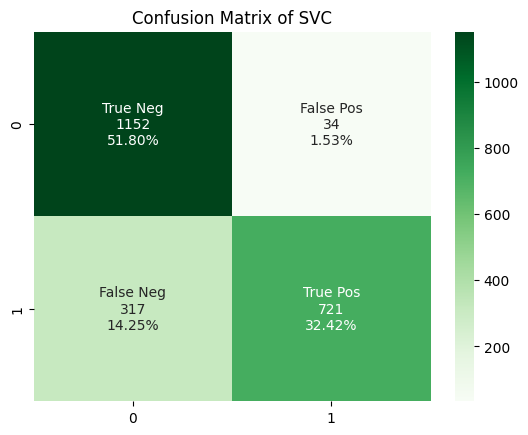

In [151]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix_svc.flatten()]
group_percentage = [
    "{0:.2%}".format(value)
    for value in confusion_matrix_svc.flatten() / np.sum(confusion_matrix_svc)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentage)
]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix_svc, annot = labels, fmt="", cmap="Greens")
plt.title("Confusion Matrix of SVC")

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Confusion Matrix of SVC.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)


plt.show()

In [152]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier(random_state=0)
xgboost_clf_pipeline = Pipeline(
    steps=[
        ("col_trans", col_trans),
        ("model", xgboost_clf)
    ]
)

In [153]:
set_config(display="diagram")
display(xgboost_clf_pipeline)

,steps,"[('col_trans', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_pipeline', ...), ('ohe_cat_pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [154]:
xgboost_clf_pipeline.fit(X_train, y_train)
score = xgboost_clf_pipeline.score(X_valid, y_valid)

print(f"Model Score: {score}")

c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(


Model Score: 0.8898381294964028


In [155]:
xgb_param_grid = {
    "model__learning_rate": np.arange(0.05, 1, 0.05),
    "model__max_depth": np.arange(3, 7, 1),
    "model__n_estimators": np.arange(50, 200, 50),
}

In [156]:
grid_search_xgb = GridSearchCV(
    xgboost_clf_pipeline,
    param_grid=xgb_param_grid,
    cv=5,
    verbose=True,
    n_jobs=1,
)

In [157]:
grid_search_xgb.fit(X_train, y_train)

print("Best Score of Train Set: " + str(grid_search_xgb.best_score_))
print("Best Parameter Set: " + str(grid_search_xgb.best_params_))
print("Test Score: " + str(grid_search_xgb.score(X_valid, y_valid)))

Fitting 5 folds for each of 228 candidates, totalling 1140 fits


c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version

Best Score of Train Set: 0.8937480833445568
Best Parameter Set: {'model__learning_rate': np.float64(0.1), 'model__max_depth': np.int64(6), 'model__n_estimators': np.int64(100)}
Test Score: 0.891636690647482


In [158]:
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_valid)

In [162]:
precision_xgb = precision_score(y_valid, y_pred_xgb)
recall_xgb = recall_score(y_valid, y_pred_xgb)
f1_xgb = f1_score(y_valid, y_pred_xgb)

print(f"Precision Score: {precision_xgb:.3f}")
print(f"Recall Score: {recall_xgb:.3f}")
print(f"F-1 Score: {f1_xgb:.3f}")

Precision Score: 0.900
Recall Score: 0.864
F-1 Score: 0.882


In [163]:
confusion_matrix_xgb = confusion_matrix(y_valid, y_pred_xgb)

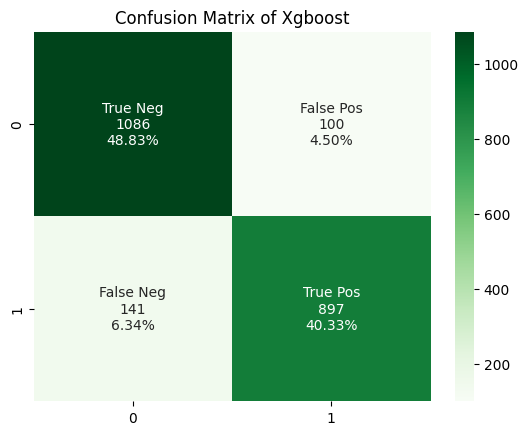

In [165]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix_xgb.flatten()]
group_percentage = [
    "{0:.2%}".format(value)
    for value in confusion_matrix_xgb.flatten() / np.sum(confusion_matrix_xgb)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentage)
]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix_xgb, annot = labels, fmt="", cmap="Greens")
plt.title("Confusion Matrix of Xgboost")

# Saving the output as png.
output_directory = Path('../data/output')
file_name = "Confusion Matrix of Xgboost.png" 
full_path = output_directory / file_name
plt.savefig(full_path, dpi=300)

plt.show()

In [168]:
import os, joblib

os.makedirs("models", exist_ok=True)      

joblib.dump(
    grid_search_xgb.best_estimator_,
    "models/classification_pipeline.joblib"
)

['models/classification_pipeline.joblib']

Influence

In [170]:
import os, glob
glob.glob("**/classification_pipeline.joblib", recursive=True)

['models\\classification_pipeline.joblib']

In [171]:
xgboost_model = joblib.load("models/classification_pipeline.joblib")
kmeans_model = joblib.load("app/models/clustering_source_location.joblib")
kmeans_destination_model = joblib.load("app/models/clustering_destination_location.joblib")

In [175]:
orders = pd.read_csv(
    "../data/input/part1-dataset.csv", parse_dates=["created_date", "first_created_at"]
)

In [176]:
orders.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,300000,250000,1
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,470000,230000,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,160000,160000,1
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,33.672604,52.686855,34.654903,53.704929,950000,530000,530000,1
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,360000,230000,1


In [177]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11118 entries, 0 to 11117
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   created_date           11118 non-null  datetime64[ns]     
 1   deliverey_category_id  11118 non-null  int64              
 2   weekday                11118 non-null  int64              
 3   first_created_at       11118 non-null  datetime64[ns, UTC]
 4   time_bucket            11118 non-null  int64              
 5   total_distance         11107 non-null  float64            
 6   sum_product            11118 non-null  int64              
 7   source_latitude        11118 non-null  float64            
 8   source_longitude       11118 non-null  float64            
 9   destination_latitude   11118 non-null  float64            
 10  destination_longitude  11118 non-null  float64            
 11  final_customer_fare    11118 non-null  int64          

In [183]:
numerical_cols = [
    "time_bucket",
    "total_distance",
    "first_created_at_hour",   
    "final_customer_fare"
]

destination_cols = ["destination_latitude", "destination_longitude"]
source_cols = ["source_latitude", "source_longitude"]

categorical_cols = [
    "deliverey_category_id",
    "weekday",
    "destination_cluster",
    "source_cluster",
]

ordinal_category_cols = ["sum_product"]
    

In [180]:
orders = orders.assign(
    first_created_at_hour=orders["first_created_at"].dt.hour,
    source_cluster=lambda df: kmeans_model.predict(df[source_cols]),
    destination_cluster=lambda df: kmeans_destination_model.predict(df[destination_cols]),
)

In [181]:
orders.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,first_created_at_hour,source_cluster,destination_cluster
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,300000,250000,1,15,2,1
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,470000,230000,1,10,1,2
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,160000,160000,1,10,2,4
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,33.672604,52.686855,34.654903,53.704929,950000,530000,530000,1,9,2,4
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,360000,230000,1,8,0,9


In [184]:
X_test = orders[numerical_cols + categorical_cols + ordinal_category_cols]

In [186]:
xgboost_model.predict(X_test)

array([0, 0, 0, ..., 1, 1, 0], shape=(11118,))